In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pickle
# 导入向量化后的数据集
np_vectorized_tfidf = pickle.load(open('model/vectorized_generated_corpus_tfidf.pkl', 'rb'))

In [3]:
np_vectorized_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17705395, 0.1748451 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.21242656,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [4]:
np_vectorized_tfidf.shape

(1200, 48)

In [5]:
np_vectorized_tfidf.dtype

dtype('float64')

In [6]:
# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = np_vectorized_tfidf,
                                      batch_size = 32,
                                      shuffle = True)

In [11]:
import torch
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # encoder
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim).double()
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim*2).double()  # 2 for mean and variance

        # decoder
        self.fc3 = torch.nn.Linear(latent_dim, hidden_dim).double()
        self.fc4 = torch.nn.Linear(hidden_dim, input_dim).double()

    def encode(self, x):
        # encoder
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # split mean and variance
        mu, log_var = x[:, :self.latent_dim], x[:, self.latent_dim:]
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # sample from a normal distribution using the mean and variance
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

In [65]:
# Model Initialization
input_dim = 48
hidden_dim = 32
latent_dim = 2
model = VAE(input_dim, hidden_dim, latent_dim)

# model.cuda()  # move the model to GPU

In [71]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),
							lr = 0.01,
							weight_decay = 0.00000001)

In [72]:
epochs = 100
iters = 0
outputs = []
losses = []

for epoch in range(1, epochs + 1):
    print('Epoch:', epoch)
    for essay in loader:
        iters += 1

        # essay = essay.cuda()  # move data to GPU

        # forward pass
        x_reconstructed, mu, log_var = model(essay)
        reconstruction_loss = loss_function(x_reconstructed, essay)
        # kl divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # total loss
        loss = reconstruction_loss + kl_loss

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.item())
        if iters % 100 == 0:
            print(f"Iteration: {iters}, loss is: {loss.item()}")

    outputs.append((epoch, essay, x_reconstructed))

Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 100, loss is: 0.017045078077196518
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 200, loss is: 0.016758482795633824
Epoch: 7
Epoch: 8
Iteration: 300, loss is: 0.01624833155670984
Epoch: 9
Epoch: 10
Epoch: 11
Iteration: 400, loss is: 0.016615184771315985
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 500, loss is: 0.016799915938315008
Epoch: 15
Epoch: 16
Iteration: 600, loss is: 0.017326898278138776
Epoch: 17
Epoch: 18
Epoch: 19
Iteration: 700, loss is: 0.016554447651231277
Epoch: 20
Epoch: 21
Epoch: 22
Iteration: 800, loss is: 0.01699663010996506
Epoch: 23
Epoch: 24
Iteration: 900, loss is: 0.016444001932424332
Epoch: 25
Epoch: 26
Epoch: 27
Iteration: 1000, loss is: 0.01587809805621665
Epoch: 28
Epoch: 29
Iteration: 1100, loss is: 0.016764006091026754
Epoch: 30
Epoch: 31
Epoch: 32
Iteration: 1200, loss is: 0.015974542464710407
Epoch: 33
Epoch: 34
Epoch: 35
Iteration: 1300, loss is: 0.01673838957396653
Epoch: 36
Epoch: 37
Iteration: 1400, loss is: 0.0162316070452

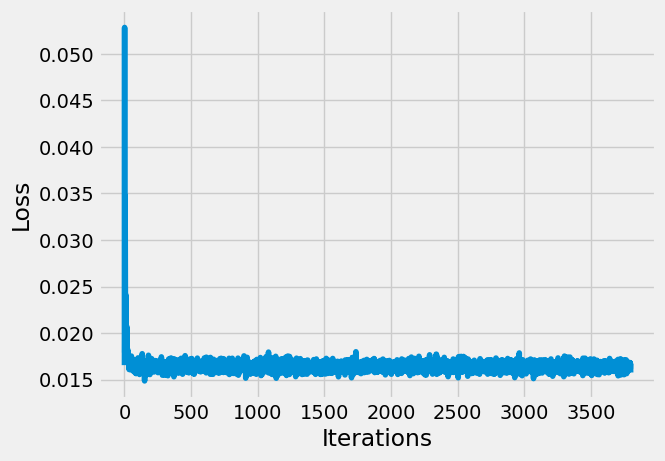

In [73]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

In [74]:
outputs[-1]

(100,
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.2175, 0.2157, 0.2116, 0.0000, 0.0000, 0.0000,
          0.6394, 0.0000, 0.2114, 0.0000, 0.2123, 0.2104, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4488, 0.0000,
          0.3422, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.2983, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.3782, 0.1855, 0.0000, 0.0000, 0.3702,
          0.1868, 0.3743, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.2885, 0.0000, 0.2925, 0.0000, 0.2880, 0.0000, 0.2962, 0.0000,
          0.0000, 0.0000, 0.2865],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.00

## 保存模型参数

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 保存模型参数在 Colab
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model/SixTypes-VAE-K-Means-TFIDF-2d.pth')

In [98]:
# 保存模型参数在本地
torch.save(model.state_dict(), 'model/SixTypes-VAE-K-Means-TFIDF-2d.pth')

## 加载模型参数

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 加载模型参数
model = VAE(input_dim, hidden_dim, latent_dim)
# model.cuda() # move the model to GPU

In [ ]:
# Colab
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model/SixTypes-VAE-K-Means-TFIDF-2d.pth'))

In [ ]:
# 本地
model.load_state_dict(torch.load('model/SixTypes-VAE-K-Means-TFIDF-2d.pth'))

In [75]:
# Dimensionality Reduction by the trained VAE model

# decomposition_data = []
# for essay in np_vectorized_tfidf:
#     essay = torch.from_numpy(essay).cuda()
#     encoded = model.encode(essay)[0]
#     decomposition_data.append(encoded.cpu().data.numpy())
#
# decomposition_data = np.array(decomposition_data)

decomposition_data = []
for essay in np_vectorized_tfidf:
    essay = torch.from_numpy(essay.reshape(1, -1))
    # encode the data
    mu, log_var = model.encode(essay)
    # sample latent variables from the mean and variance
    encoded = model.reparameterize(mu, log_var)
    decomposition_data.append(encoded.cpu().data.numpy())

decomposition_data = np.array(decomposition_data).reshape(-1, 2)

In [76]:
decomposition_data

array([[ 0.53081422,  0.05729707],
       [ 2.66566672,  1.58091095],
       [-1.70050119,  0.81505201],
       ...,
       [-1.12022525, -1.28146722],
       [ 0.68827471,  0.88680054],
       [-0.70324266,  2.10884446]])

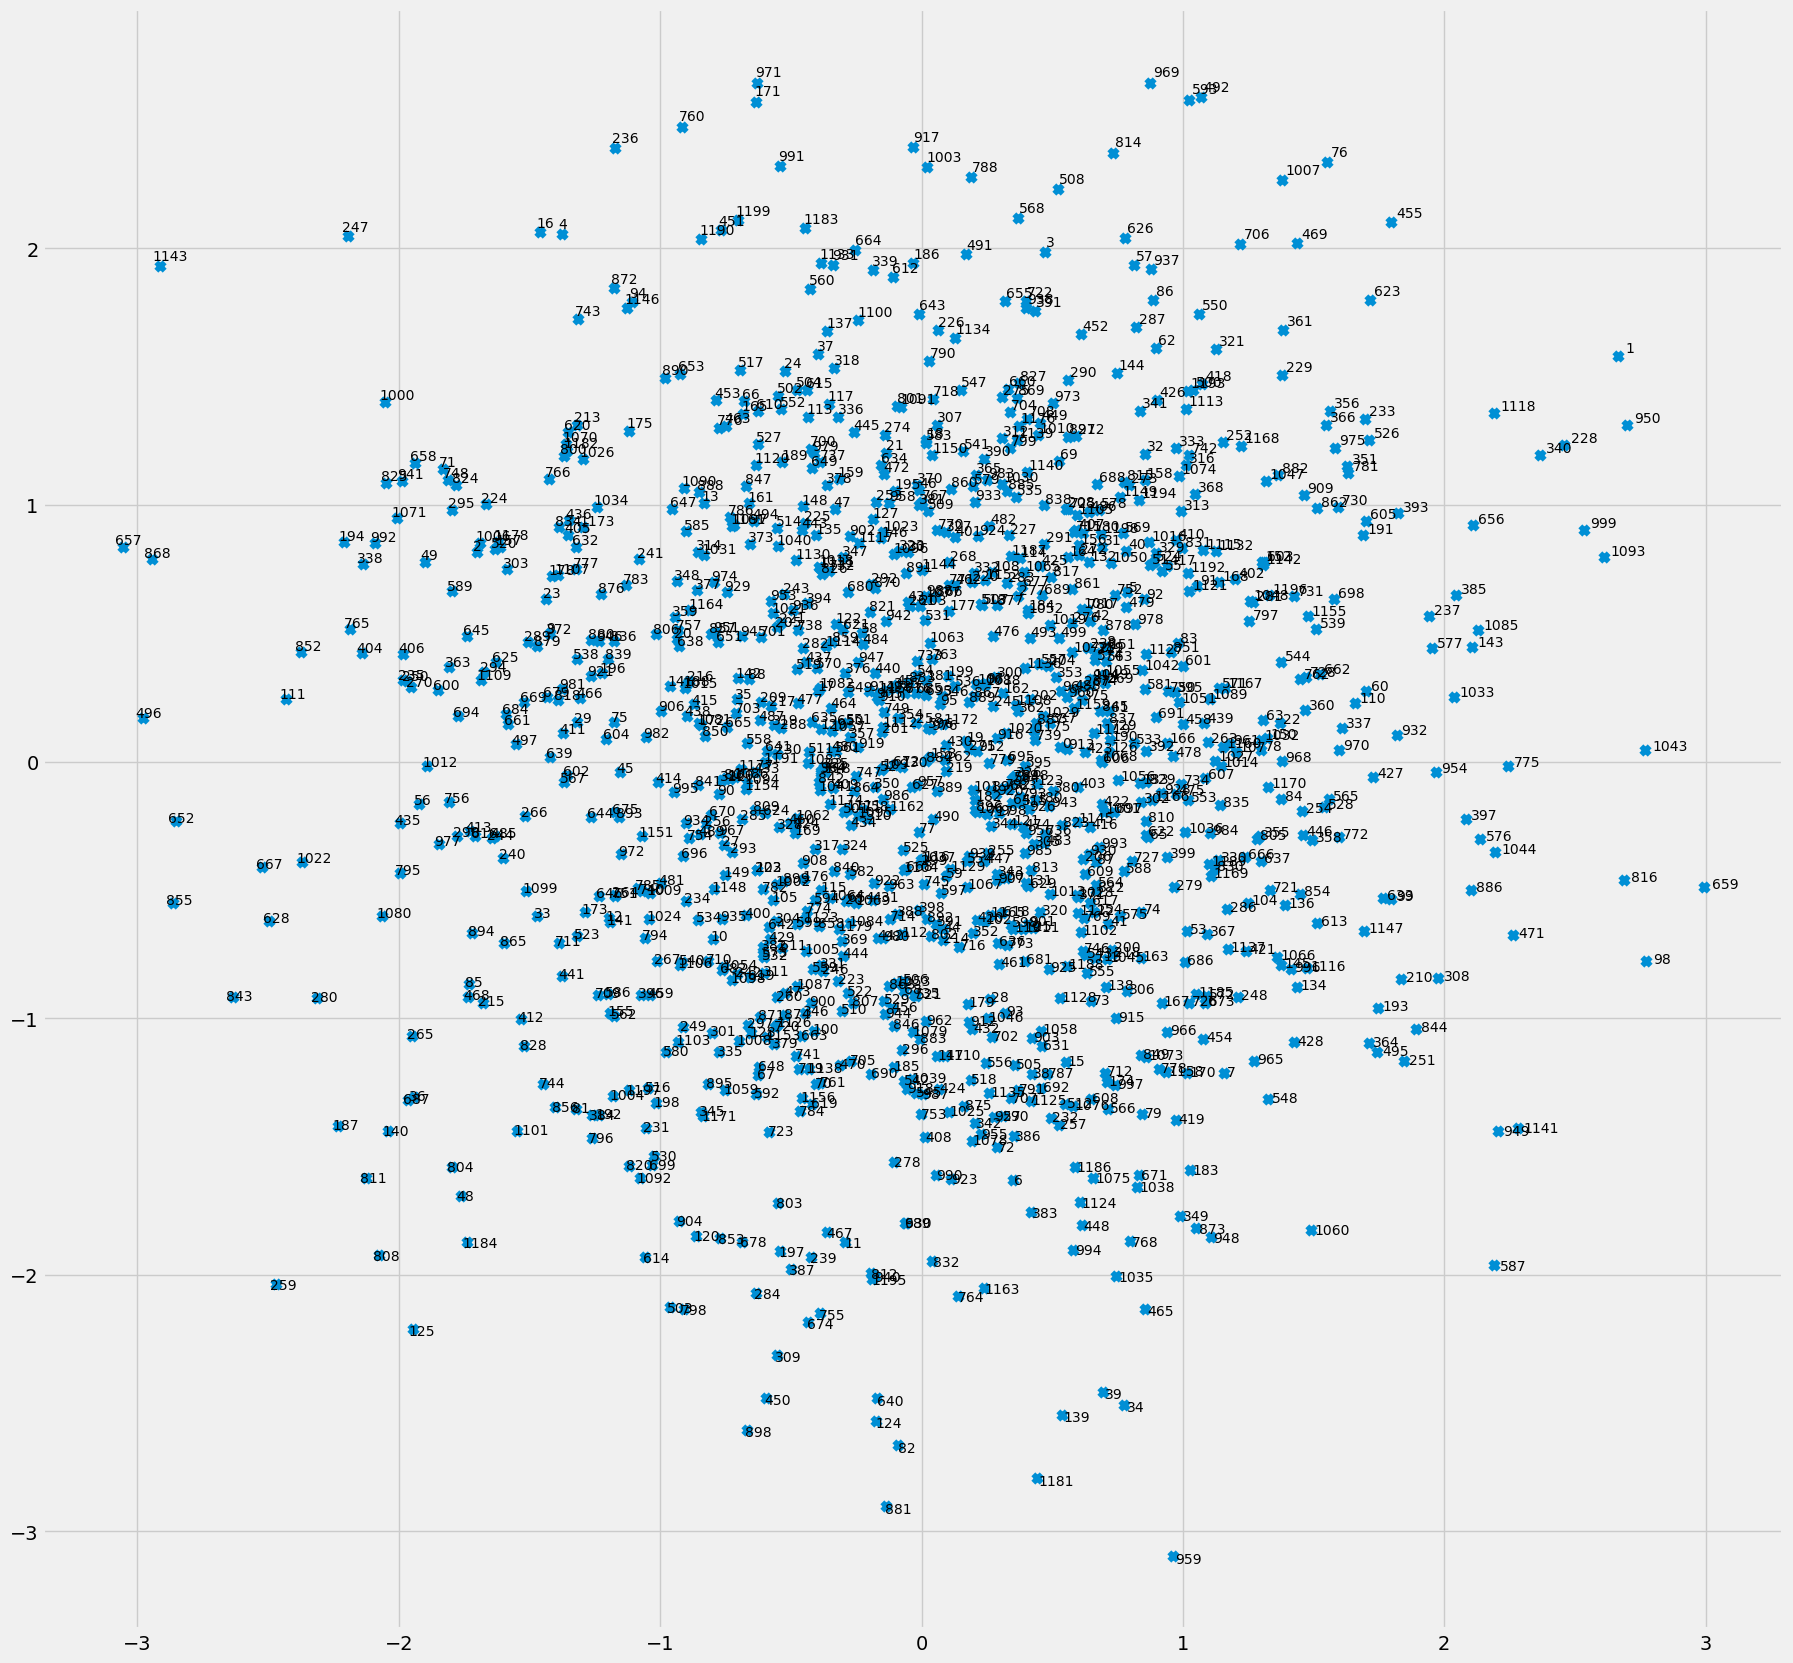

In [77]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], marker='x')
for i in range(len(decomposition_data)):
    plt.text(decomposition_data[:, 0][i] * 1.01, decomposition_data[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

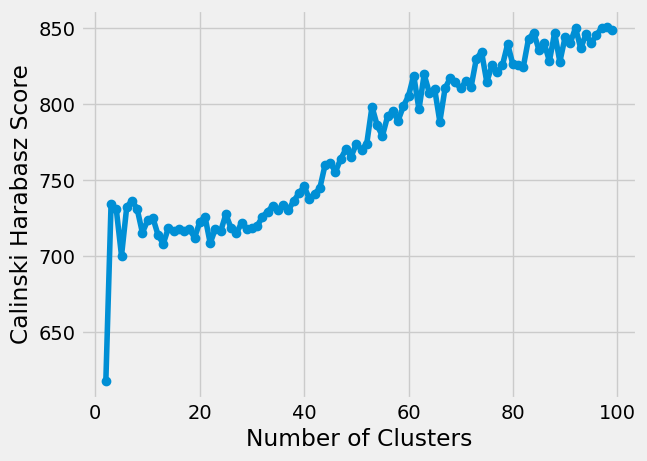

In [78]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [79]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

96

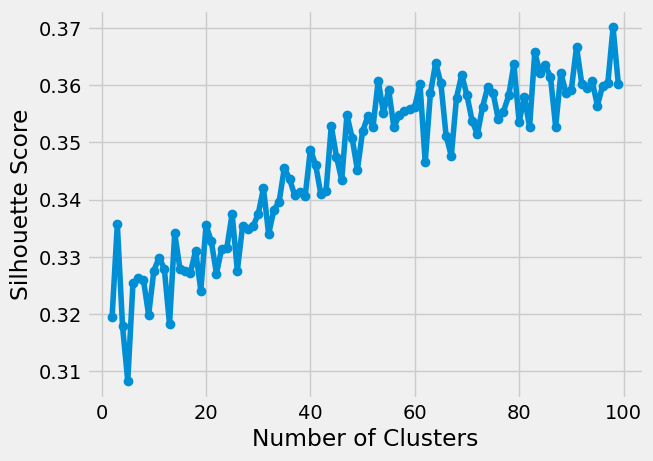

In [80]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [81]:
silhouette_score_list.index(max(silhouette_score_list))

96

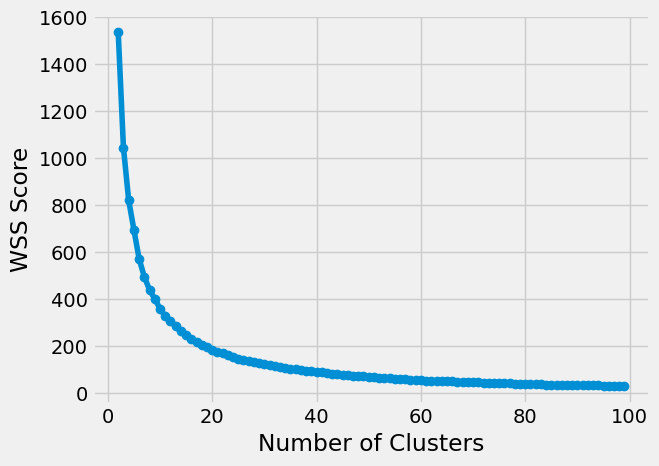

In [82]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

In [83]:
# 选用 k 值做 K-means 算法聚类
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [84]:
print(y_pred[:10])

[5 3 4 1 1 3 2 2 3 4]


In [85]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data[i]))

In [86]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

5 -0.1320575853038134
3 1.0944080951847532
4 -1.543215207676164
1 -0.12405010409530741
2 0.891550554472836
0 -0.7188587827822104


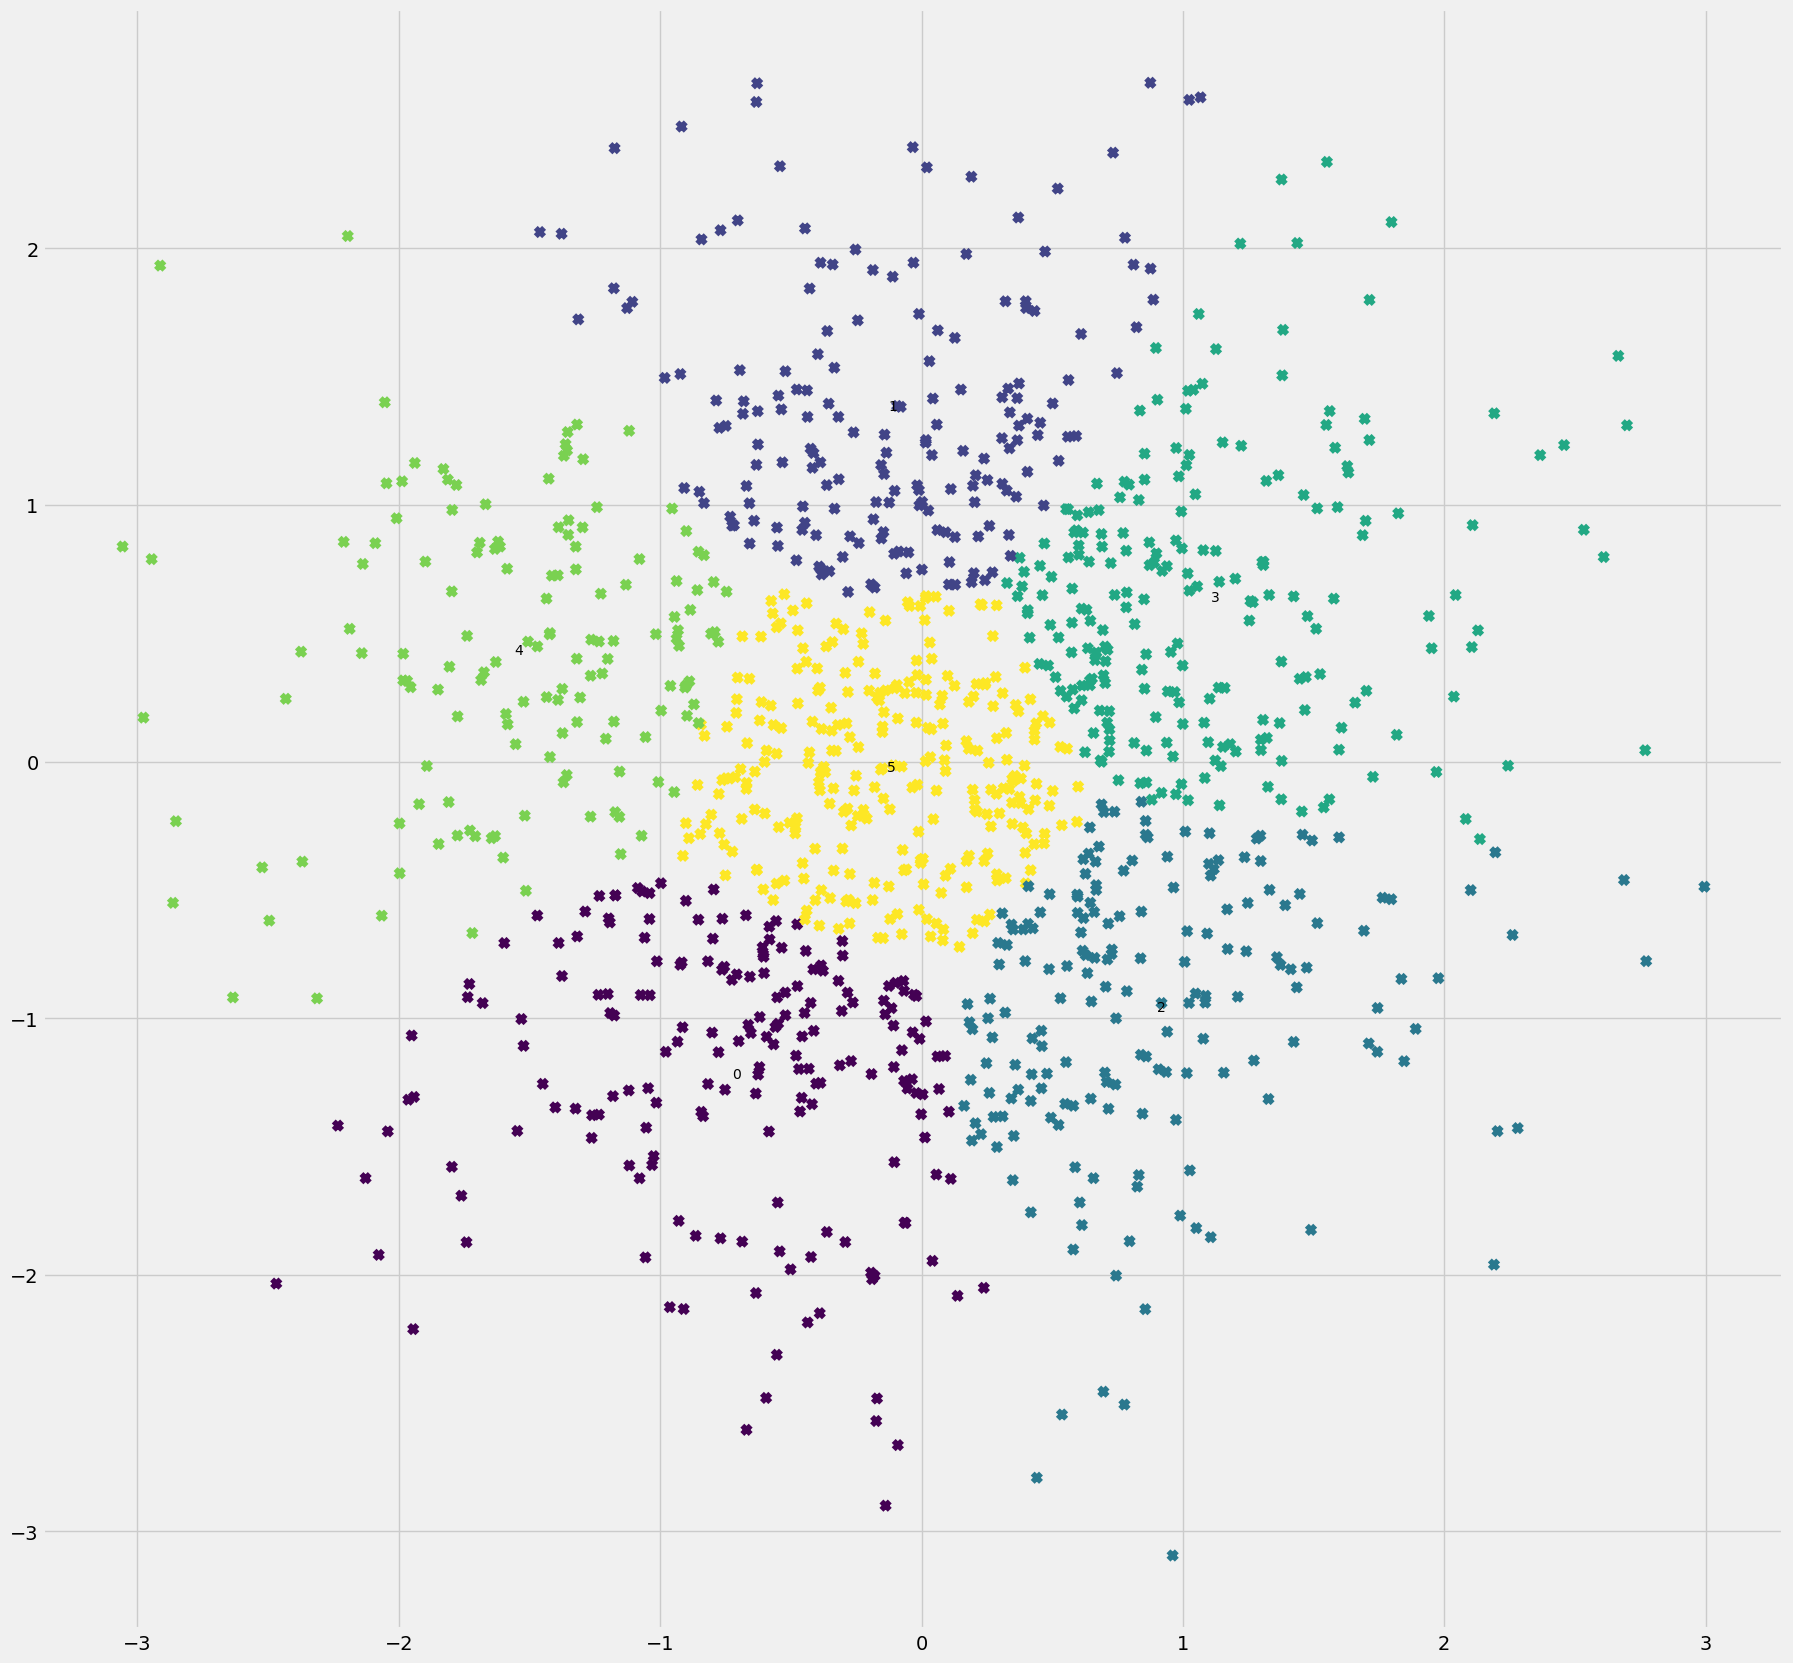

In [87]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [88]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

732.3404874791223

In [89]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.3254352856046735

In [90]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [91]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [92]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.homogeneity_score(labels, y_pred)

0.006038296465331378

In [93]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.completeness_score(labels, y_pred)

0.0061122830180847885

In [94]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.v_measure_score(labels, y_pred)

0.006075064484550767

In [95]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.00017001271171398073

In [96]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

0.0001844998925011154

In [97]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.16982243587936574